In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [3]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

import random 
from types import SimpleNamespace

import torch

from torch.utils.data import DataLoader

from models.autoencoder import VariationalAutoEncoder, AutoEncoder
from models.mlp import MLP
from utils.data_utils import TorchDataset

from utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
thefts = pd.read_csv("../dataset/final/valid_train_thefts.csv")
non_thefts = pd.read_csv("../dataset/final/valid_train_non_theft_suc_theft_acct.csv")
non_thefts2 = pd.read_csv("../dataset/final/non_thefts_k_100000.csv")
non_thefts3 = pd.read_csv("../dataset/final/non_thefts_k_200000.csv")
non_thefts4 = pd.read_csv("../dataset/final/non_thefts_k_300000.csv")
non_thefts5 = pd.read_csv("../dataset/final/non_thefts_k_400000.csv")
non_thefts6 = pd.read_csv("../dataset/final/non_thefts_k_500000.csv")
non_thefts7 = pd.read_csv("../dataset/final/non_thefts_k_600000.csv")
non_thefts8 = pd.read_csv("../dataset/final/non_thefts_k_700000.csv")
non_thefts9 = pd.read_csv("../dataset/final/non_thefts_k_709000.csv")

non_thefts8['target'] = 0

non_thefts = pd.concat([non_thefts, non_thefts2, non_thefts3,
                       non_thefts4, non_thefts5, non_thefts6,
                       non_thefts7, non_thefts8, non_thefts9])
thefts.drop(columns=['acct', 'successor', 'voltage'], inplace=True)
non_thefts.drop(columns=['acct', 'successor', 'voltage'], inplace=True)
print(len(non_thefts))
non_thefts.drop_duplicates(inplace=True)
print(len(non_thefts))

711808
699187


In [10]:
non_thefts.head()

,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,min_measurement_interval_in_days,mean_measurement_interval_in_days,median_measurement_interval_in_days,days_since_last_measurement,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target
0,4,0,11.444444,9.086538,10.463880,10.860656,1.002664,122,9,78.333333,104.0,106,0,1,12.0,0,0,0
1,6,0,7.290323,5.607143,6.254461,6.030303,0.568356,132,112,121.600000,121.0,213,3,1,35.0,0,0,0
2,3,0,4.264463,1.000000,2.632231,2.632231,1.632231,121,6,63.500000,63.5,142,2,2,25.0,0,0,0
3,3,0,17.456140,12.758929,15.107534,15.107534,2.348606,112,57,84.500000,84.5,1543,2,2,25.0,0,2,0
4,10,0,20.971014,2.967480,6.842664,3.920000,6.070888,250,69,129.777778,121.0,618,0,1,12.0,0,1,0


In [11]:
df = pd.concat([thefts, non_thefts])
df.fillna(-1, inplace=True)

In [12]:
scaler = MinMaxScaler()

In [13]:
#df.drop(['xrhsh', 'parno', 'acct_control', 'contract_capacity', 'min_measurement_interval_in_days', 'max_energy_per_day'], axis=1, inplace=True)
print("Bincount of y:", df['target'].value_counts())

Bincount of y: 0    699187
1      1555
Name: target, dtype: int64


In [14]:
df.head()

,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,min_measurement_interval_in_days,mean_measurement_interval_in_days,median_measurement_interval_in_days,days_since_last_measurement,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target
0,12,2,18.950000,0.000000,6.735356,7.049180,4.964937,350,15,144.181818,122.0,152,0,1,12.0,0,0,1
1,13,2,12.071429,0.000000,7.221644,10.070525,4.807979,243,6,122.416667,121.0,341,0,1,12.0,0,1,1
2,5,5,0.000000,0.000000,0.000000,0.000000,0.000000,125,120,122.250000,122.0,1251,2,1,25.0,0,3,1
3,6,1,9.434066,4.546448,5.873035,4.989218,1.803735,371,68,197.200000,182.0,190,2,6,25.0,0,0,1
4,8,0,19.565574,1.910569,10.585130,10.008197,5.580233,246,121,139.142857,121.0,821,3,1,35.0,0,5,1


In [15]:
train = df[df['target'] == 0]
train, val = train_test_split(train, test_size=0.5, random_state=42, shuffle=True)

test_target1 = df[(df['target'] == 1)]

In [16]:
train.target.value_counts(), val.target.value_counts(), test_target1.target.value_counts()

(0    349593
 Name: target, dtype: int64,
 0    349594
 Name: target, dtype: int64,
 1    1555
 Name: target, dtype: int64)

In [17]:
X_train = train.drop('target', axis=1)
y_train = train['target']
X_val = val.drop('target', axis=1)
y_val = val['target']
X_test_1 = test_target1.drop('target', axis=1)
y_test_1 = test_target1['target']

In [18]:
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test_1 = scaler.transform(X_test_1)

In [19]:
train_dataset = TorchDataset(
    X=torch.tensor(X_train).float(),
    y=torch.tensor(y_train.to_numpy()).float()
)  # reconstruction
val_dataset = TorchDataset(
    X=torch.tensor(X_val).float(),
    y=torch.tensor(y_val.to_numpy()).float()
)

test_dataset_one = TorchDataset(
    X=torch.tensor(X_test_1).float(),
    y=torch.tensor(y_test_1.to_numpy()).float()
)

X_test = np.concatenate([X_val, X_test_1], axis=0)
y_test = pd.concat([y_val, y_test_1])
test_dataset = TorchDataset(
    X=torch.tensor(X_test).float(),
    y=torch.tensor(y_test.to_numpy()).float()
)

In [20]:
np.bincount(y_train), np.bincount(y_val), np.bincount(y_test)

(array([349593]), array([349594]), array([349594,   1555]))

In [25]:
train_loader = DataLoader(
    train_dataset, batch_size=512, shuffle=False
)
val_loader = DataLoader(
    val_dataset, batch_size=512, shuffle=False
)
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)
test_zero = DataLoader(
    test_dataset_one, batch_size=1, shuffle=False
)

In [26]:
encoder = MLP(
    in_size=X_train.shape[1],
    layer_units=[16, 8],
    out_size=4,
    vae=False)
decoder = MLP(
    in_size=4, 
    layer_units=[8, 16],
    out_size=X_train.shape[1]
)
model = AutoEncoder(encoder, decoder)
model

AutoEncoder(
  (encoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=17, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=8, bias=True)
      (3): ReLU()
      (4): Linear(in_features=8, out_features=4, bias=True)
    )
  )
  (decoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=17, bias=True)
    )
  )
)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.SmoothL1Loss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
args = dict(model=model, train_loader=train_loader, 
            test_loader=val_loader,
            epochs=1_000, optimizer=optimizer, 
            criterion=criterion,
            reconstruction=True, vae=False,
            device=device, verbose=True, return_best=True)

Epoch: 1/1000
[Train]	Loss=0.012772909867219998
[Test]	Loss=0.001838182142797972

Epoch: 2/1000
[Train]	Loss=0.00124293404404963
[Test]	Loss=0.0008398638560953461

Epoch: 3/1000
[Train]	Loss=0.000760282942749789
[Test]	Loss=0.0007115262970471506

Epoch: 4/1000
[Train]	Loss=0.0006409647017100343
[Test]	Loss=0.0005931796929693344

Epoch: 5/1000
[Train]	Loss=0.000529441908959812
[Test]	Loss=0.0004954114856299335

Epoch: 6/1000
[Train]	Loss=0.0004810516896867636
[Test]	Loss=0.00046886780822007353

Epoch: 7/1000
[Train]	Loss=0.00044002040070488416
[Test]	Loss=0.000413032069391166

Epoch: 8/1000
[Train]	Loss=0.0003949190882998648
[Test]	Loss=0.00038566133790611295

Epoch: 9/1000
[Train]	Loss=0.0003785297943082792
[Test]	Loss=0.0003753178116765233

Epoch: 10/1000
[Train]	Loss=0.00037079240850140214
[Test]	Loss=0.0003683000487155427

Epoch: 11/1000
[Train]	Loss=0.0003631114509310519
[Test]	Loss=0.00035837329602813944

Epoch: 12/1000
[Train]	Loss=0.00035220513736970976
[Test]	Loss=0.00034623626

Epoch: 97/1000
[Train]	Loss=0.0002873185444866971
[Test]	Loss=0.0002877966764244615

Epoch: 98/1000
[Train]	Loss=0.00028730769378612414
[Test]	Loss=0.0002877727536510848

Epoch: 99/1000
[Train]	Loss=0.0002872874469586306
[Test]	Loss=0.00028777451922665015

Epoch: 100/1000
[Train]	Loss=0.0002872751817607633
[Test]	Loss=0.0002877691088543965

Epoch: 101/1000
[Train]	Loss=0.00028726178679736616
[Test]	Loss=0.00028777563482377063

Epoch: 102/1000
[Train]	Loss=0.0002872478519643058
[Test]	Loss=0.00028772660812170764

Epoch: 103/1000
[Train]	Loss=0.0002872272724881264
[Test]	Loss=0.00028773165868027997

Epoch: 104/1000
[Train]	Loss=0.0002872145397540545
[Test]	Loss=0.00028771023295589995

Epoch: 105/1000
[Train]	Loss=0.0002872003409837674
[Test]	Loss=0.00028768118132484633

Epoch: 106/1000
[Train]	Loss=0.00028715629610751167
[Test]	Loss=0.00028766544145773304

Epoch: 107/1000
[Train]	Loss=0.0002871492029330318
[Test]	Loss=0.00028764489792457116

Epoch: 108/1000
[Train]	Loss=0.000287117233781

[Test]	Loss=0.0002828563811867

Epoch: 192/1000
[Train]	Loss=0.00028242046173439
[Test]	Loss=0.000282762406707849

Epoch: 193/1000
[Train]	Loss=0.0002823643884538041
[Test]	Loss=0.00028271955042265457

Epoch: 194/1000
[Train]	Loss=0.00028231271551898104
[Test]	Loss=0.0002826708185513426

Epoch: 195/1000
[Train]	Loss=0.00028227686149608154
[Test]	Loss=0.0002826190411324898

Epoch: 196/1000
[Train]	Loss=0.00028224024979351975
[Test]	Loss=0.00028260028516256016

Epoch: 197/1000
[Train]	Loss=0.0002822038340411254
[Test]	Loss=0.00028256641522831917

Epoch: 198/1000
[Train]	Loss=0.0002821670887293976
[Test]	Loss=0.0002825244068318779

Epoch: 199/1000
[Train]	Loss=0.0002821356541636341
[Test]	Loss=0.00028248555213161833

Epoch: 200/1000
[Train]	Loss=0.0002821009791015387
[Test]	Loss=0.00028241661476621766

Epoch: 201/1000
[Train]	Loss=0.0002820661542591152
[Test]	Loss=0.0002823687075176392

Epoch: 202/1000
[Train]	Loss=0.0002820256376576966
[Test]	Loss=0.00028233992331797643

Epoch: 203/1000


[Test]	Loss=0.00027699430900459527

Epoch: 287/1000
[Train]	Loss=0.00027669783410023746
[Test]	Loss=0.0002768686920785213

Epoch: 288/1000
[Train]	Loss=0.00027655233386757416
[Test]	Loss=0.0002766837080256089

Epoch: 289/1000
[Train]	Loss=0.00027637012748338833
[Test]	Loss=0.0002764276499472392

Epoch: 290/1000
[Train]	Loss=0.00027615440183842085
[Test]	Loss=0.00027614271311371657

Epoch: 291/1000
[Train]	Loss=0.0002759117343344373
[Test]	Loss=0.00027591240018576187

Epoch: 292/1000
[Train]	Loss=0.0002756483716846581
[Test]	Loss=0.00027558416584360046

Epoch: 293/1000
[Train]	Loss=0.0002753481301352911
[Test]	Loss=0.0002752249617234219

Epoch: 294/1000
[Train]	Loss=0.0002750085966251136
[Test]	Loss=0.0002748438930842892

Epoch: 295/1000
[Train]	Loss=0.00027461969973737615
[Test]	Loss=0.00027434549386538755

Epoch: 296/1000
[Train]	Loss=0.00027415314801347524
[Test]	Loss=0.0002737517651137425

Epoch: 297/1000
[Train]	Loss=0.0002735580939296388
[Test]	Loss=0.0002730677916690854

Epoch: 2

[Test]	Loss=0.00022131182295716836

Epoch: 381/1000
[Train]	Loss=0.00022164604987602785
[Test]	Loss=0.00022128744185172665

Epoch: 382/1000
[Train]	Loss=0.0002216320567287772
[Test]	Loss=0.0002212674887257725

Epoch: 383/1000
[Train]	Loss=0.00022161935309853573
[Test]	Loss=0.0002212637778382481

Epoch: 384/1000
[Train]	Loss=0.0002216143941765482
[Test]	Loss=0.00022126125688405536

Epoch: 385/1000
[Train]	Loss=0.00022160400766715692
[Test]	Loss=0.00022126438865648776

Epoch: 386/1000
[Train]	Loss=0.00022160766226454948
[Test]	Loss=0.00022125859507669777

Epoch: 387/1000
[Train]	Loss=0.00022160644961915103
[Test]	Loss=0.00022127228778975132

Epoch: 388/1000
[Train]	Loss=0.0002215992340423974
[Test]	Loss=0.0002212611976324064

Epoch: 389/1000
[Train]	Loss=0.00022160532121719742
[Test]	Loss=0.00022126518168260302

Epoch: 390/1000
[Train]	Loss=0.00022160399565064126
[Test]	Loss=0.0002212351743337435

Epoch: 391/1000
[Train]	Loss=0.0002215909026767704
[Test]	Loss=0.00022122093205685192

Epoc

[Test]	Loss=0.00022103353564581108

Epoch: 475/1000
[Train]	Loss=0.00022143039168547266
[Test]	Loss=0.00022103167359722645

Epoch: 476/1000
[Train]	Loss=0.00022143121724566486
[Test]	Loss=0.00022102849652849569

Epoch: 477/1000
[Train]	Loss=0.0002214320089721215
[Test]	Loss=0.0002210106964255131

Epoch: 478/1000
[Train]	Loss=0.00022141989406592336
[Test]	Loss=0.00022104375814254728

Epoch: 479/1000
[Train]	Loss=0.00022143205414058457
[Test]	Loss=0.00022101310925237087

Epoch: 480/1000
[Train]	Loss=0.00022142127971505775
[Test]	Loss=0.00022101224457458517

Epoch: 481/1000
[Train]	Loss=0.00022141964783388193
[Test]	Loss=0.00022102159397771357

Epoch: 482/1000
[Train]	Loss=0.00022142272874918161
[Test]	Loss=0.0002210076909330244

Epoch: 483/1000
[Train]	Loss=0.0002214205469419678
[Test]	Loss=0.0002209988980181447

Epoch: 484/1000
[Train]	Loss=0.00022142205853015184
[Test]	Loss=0.00022103113253443403

Epoch: 485/1000
[Train]	Loss=0.00022141654789243248
[Test]	Loss=0.00022099518370037382

E

[Test]	Loss=0.00022085421064736984

Epoch: 569/1000
[Train]	Loss=0.00022133256376146218
[Test]	Loss=0.00022086291787000496

Epoch: 570/1000
[Train]	Loss=0.0002213347303988903
[Test]	Loss=0.00022086292515661552

Epoch: 571/1000
[Train]	Loss=0.0002213312423282465
[Test]	Loss=0.0002208767014526316

Epoch: 572/1000
[Train]	Loss=0.00022132754188060276
[Test]	Loss=0.00022084571610001702

Epoch: 573/1000
[Train]	Loss=0.00022133007900595753
[Test]	Loss=0.00022086735277390313

Epoch: 574/1000
[Train]	Loss=0.0002213309004541151
[Test]	Loss=0.00022085852858199333

Epoch: 575/1000
[Train]	Loss=0.00022132599260231908
[Test]	Loss=0.0002208726595782799

Epoch: 576/1000
[Train]	Loss=0.00022133096645972767
[Test]	Loss=0.00022083777395018415

Epoch: 577/1000
[Train]	Loss=0.00022133090288298528
[Test]	Loss=0.00022084542367683033

Epoch: 578/1000
[Train]	Loss=0.0002213274483264889
[Test]	Loss=0.0002208633318219244

Epoch: 579/1000
[Train]	Loss=0.00022133304376160593
[Test]	Loss=0.00022084173654536083

Epo

[Test]	Loss=0.0002201012702647523

Epoch: 663/1000
[Train]	Loss=0.00022070374056280318
[Test]	Loss=0.0002200943341998228

Epoch: 664/1000
[Train]	Loss=0.00022069415566579632
[Test]	Loss=0.0002200938670258181

Epoch: 665/1000
[Train]	Loss=0.00022068574118593606
[Test]	Loss=0.00022007443195230724

Epoch: 666/1000
[Train]	Loss=0.00022069376736615496
[Test]	Loss=0.00022008071088001655

Epoch: 667/1000
[Train]	Loss=0.00022068379979425874
[Test]	Loss=0.0002200817505642908

Epoch: 668/1000
[Train]	Loss=0.00022067961604406002
[Test]	Loss=0.0002200842619095322

Epoch: 669/1000
[Train]	Loss=0.00022067588419155088
[Test]	Loss=0.00022007305022345454

Epoch: 670/1000
[Train]	Loss=0.00022067776948484928
[Test]	Loss=0.0002200736346863221

Epoch: 671/1000
[Train]	Loss=0.00022066903107040758
[Test]	Loss=0.00022007583941866153

Epoch: 672/1000
[Train]	Loss=0.00022067623980797412
[Test]	Loss=0.00022007188146816646

Epoch: 673/1000
[Train]	Loss=0.00022066435513310242
[Test]	Loss=0.0002200539740474723

Epo

[Test]	Loss=0.0002199692335151924

Epoch: 757/1000
[Train]	Loss=0.0002205934104769413
[Test]	Loss=0.00021995053609381778

Epoch: 758/1000
[Train]	Loss=0.00022059186840004465
[Test]	Loss=0.00021996246005673

Epoch: 759/1000
[Train]	Loss=0.00022058800244833428
[Test]	Loss=0.0002199567417079981

Epoch: 760/1000
[Train]	Loss=0.00022059596743806924
[Test]	Loss=0.0002199579529045968

Epoch: 761/1000
[Train]	Loss=0.00022058875995754955
[Test]	Loss=0.00021995590072234966

Epoch: 762/1000
[Train]	Loss=0.00022058949682136826
[Test]	Loss=0.00021994376580993132

Epoch: 763/1000
[Train]	Loss=0.0002205921666184304
[Test]	Loss=0.00021995848670208453

Epoch: 764/1000
[Train]	Loss=0.00022060014468997492
[Test]	Loss=0.00021995897209261563

Epoch: 765/1000
[Train]	Loss=0.00022059050228840114
[Test]	Loss=0.0002199546883539276

Epoch: 766/1000
[Train]	Loss=0.00022059150074579988
[Test]	Loss=0.00021994131111702166

Epoch: 767/1000
[Train]	Loss=0.00022058802200713103
[Test]	Loss=0.0002199558270679266

Epoch:

[Test]	Loss=0.00021994639991964644

Epoch: 851/1000
[Train]	Loss=0.00022059154536031012
[Test]	Loss=0.00021994227505889674

Epoch: 852/1000
[Train]	Loss=0.00022058037801176626
[Test]	Loss=0.00021994926651911113

Epoch: 853/1000
[Train]	Loss=0.00022058642538718464
[Test]	Loss=0.00021993700332399648

Epoch: 854/1000
[Train]	Loss=0.00022058657991872366
[Test]	Loss=0.00021994458248557203

Epoch: 855/1000
[Train]	Loss=0.0002205791470646179
[Test]	Loss=0.00021995036839524566

Epoch: 856/1000
[Train]	Loss=0.00022058600627924255
[Test]	Loss=0.00021994835247560423

Epoch: 857/1000
[Train]	Loss=0.00022059179598136257
[Test]	Loss=0.00021995108427277373

Epoch: 858/1000
[Train]	Loss=0.00022058758476788606
[Test]	Loss=0.0002199332763292277

Epoch: 859/1000
[Train]	Loss=0.00022058762034870367
[Test]	Loss=0.0002199445622236813

Epoch: 860/1000
[Train]	Loss=0.00022058143650913152
[Test]	Loss=0.0002199416185608529

Epoch: 861/1000
[Train]	Loss=0.0002205891064337508
[Test]	Loss=0.000219945222258501

Epo

[Test]	Loss=0.00021995392349418417

Epoch: 945/1000
[Train]	Loss=0.00022057953468247114
[Test]	Loss=0.00021994995501858496

Epoch: 946/1000
[Train]	Loss=0.0002205797006339612
[Test]	Loss=0.00021994903822661967

Epoch: 947/1000
[Train]	Loss=0.00022057611438582787
[Test]	Loss=0.00021996414854762582

Epoch: 948/1000
[Train]	Loss=0.0002205805683158758
[Test]	Loss=0.00021995745590236174

Epoch: 949/1000
[Train]	Loss=0.00022058491175363623
[Test]	Loss=0.00021995239077056834

Epoch: 950/1000
[Train]	Loss=0.00022058772133856923
[Test]	Loss=0.00021994832373397374

Epoch: 951/1000
[Train]	Loss=0.00022058521542632693
[Test]	Loss=0.00021995772135230586

Epoch: 952/1000
[Train]	Loss=0.00022058125214936215
[Test]	Loss=0.00021995381685826072

Epoch: 953/1000
[Train]	Loss=0.00022057881727091978
[Test]	Loss=0.00021996359936729358

Epoch: 954/1000
[Train]	Loss=0.0002205814097489477
[Test]	Loss=0.00021994352000400747

Epoch: 955/1000
[Train]	Loss=0.0002205761784099937
[Test]	Loss=0.00021995449939208843



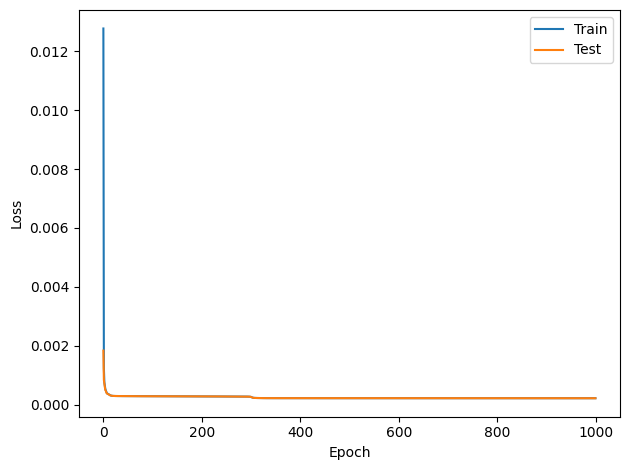

In [28]:
args = SimpleNamespace(**args)
model = model.fit(args)

In [29]:
tmp_train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=False
)
tmp_val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False
)

In [30]:
def make_preds(model, data_loader):
    loss_dist = []
    model.eval()
    for x, _ in data_loader:
        x = x.to(device)
        sample = model(x)
        loss = torch.nn.MSELoss()(x, sample)
        loss_dist.append(loss.item())
    return loss_dist  

In [31]:
def plot_loss_dist(loss_dist):
    loss = []
    for i in loss_dist:
        loss.append((i,i))
    plt.scatter(*zip(*loss))
    plt.show()
    plt.close()
    
    plt.hist(loss_dist, bins=50)
    plt.show()
    plt.close()

In [32]:
train_loss_dist = make_preds(model, tmp_train_loader)

In [33]:
len(train_loss_dist)

349593

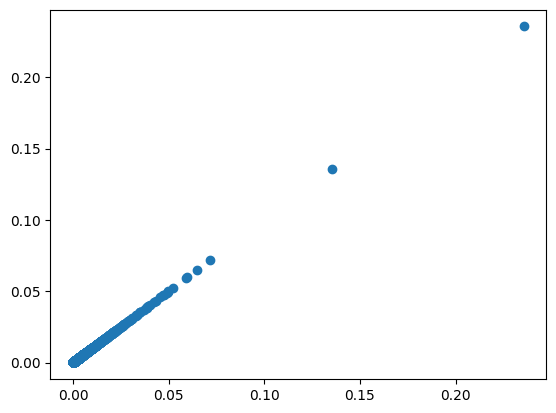

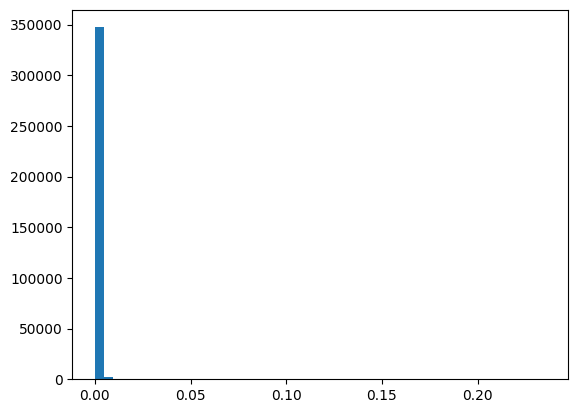

In [34]:
plot_loss_dist(train_loss_dist)

349594


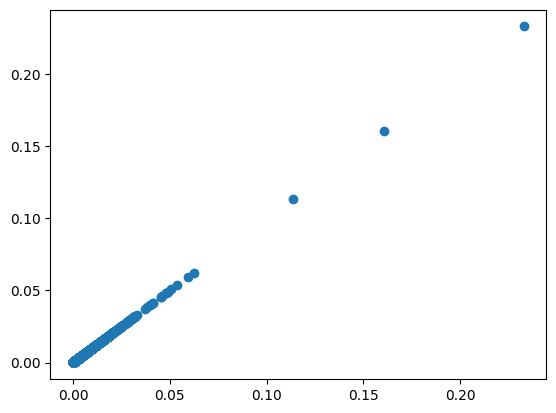

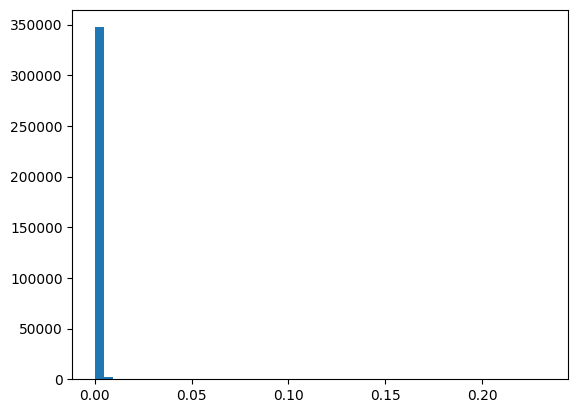

In [35]:
val_loss_dist = make_preds(model, tmp_val_loader)
print(len(val_loss_dist))
plot_loss_dist(val_loss_dist)

In [36]:
sorted_train = sorted(train_loss_dist, reverse=True)
print("Train", sorted_train[:10])
print("\n\n")

sorted_val = sorted(val_loss_dist, reverse=True)
print("Val", sorted_val[:10])
print("\n\n")

print(f"Train Mean: {statistics.mean(train_loss_dist)}, Median: {statistics.median(train_loss_dist)}")
print(f"Val Mean: {statistics.mean(val_loss_dist)}, Median: {statistics.mean(val_loss_dist)}")

Train [0.23567993938922882, 0.1356135904788971, 0.07184524834156036, 0.06484805792570114, 0.059697475284338, 0.0590842179954052, 0.05250927805900574, 0.04992702975869179, 0.04970714822411537, 0.04895816743373871]



Val [0.2329227477312088, 0.16069059073925018, 0.1136699840426445, 0.06227777898311615, 0.05934096872806549, 0.0535222627222538, 0.05070139467716217, 0.0491722896695137, 0.04817105084657669, 0.047842442989349365]



Train Mean: 0.00043977108177216786, Median: 0.00019491415878292173
Val Mean: 0.0004398431313989163, Median: 0.0004398431313989163


In [37]:
np.mean(train_loss_dist) + 2*np.std(train_loss_dist), np.mean(train_loss_dist) + np.std(train_loss_dist)

(0.0025230547291192496, 0.0014814129054457087)

1555


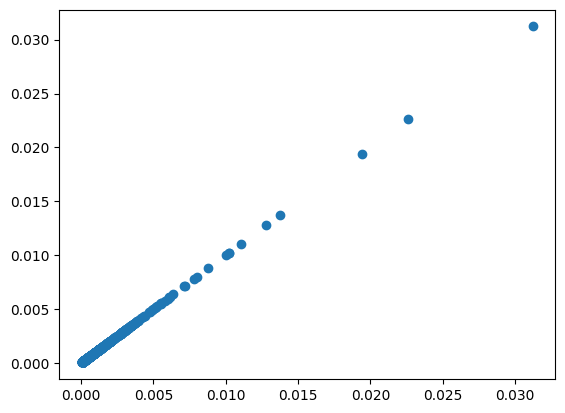

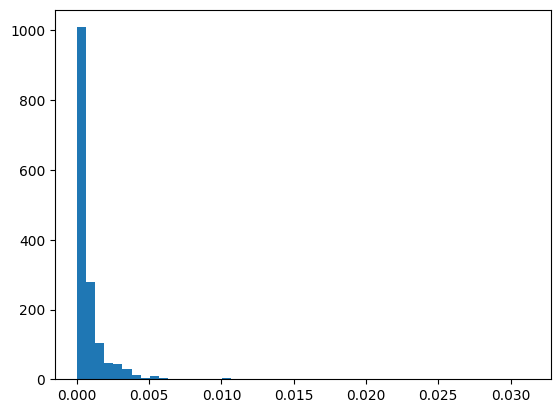

In [38]:
test_zero_loss_dist = make_preds(model, test_zero)
print(len(test_zero_loss_dist))
plot_loss_dist(test_zero_loss_dist)

In [39]:
sorted_test = sorted(test_zero_loss_dist, reverse=True)
print("Test zero", sorted_test[:10])
print("\n\n")

print(f"Test Mean: {statistics.mean(test_zero_loss_dist)}, Median: {statistics.median(test_zero_loss_dist)}")

Test zero [0.031223773956298828, 0.022604212164878845, 0.01943272352218628, 0.013759722001850605, 0.012782157398760319, 0.011082225479185581, 0.010199371725320816, 0.010189931839704514, 0.010037618689239025, 0.008788352832198143]



Test Mean: 0.0008784592828539857, Median: 0.0004244500014465302


In [40]:
np.percentile(train_loss_dist, 20), np.percentile(val_loss_dist, 20), np.percentile(test_zero_loss_dist, 20)

(0.00011192423844477161, 0.00011228385119466111, 0.00019220890826545658)

In [41]:
zero_below, zero_above = [], [] 
for i in test_zero_loss_dist:
    if i < 0.00015:
        zero_below.append(i)
    else:
        zero_above.append(i)
len(zero_below), len(zero_above)

(188, 1367)

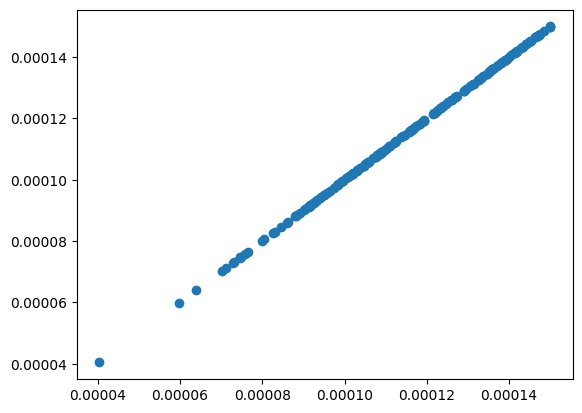

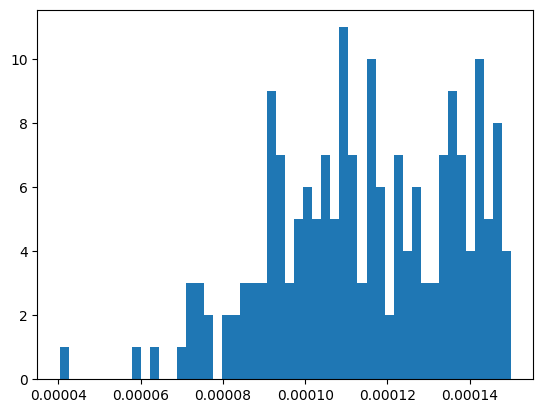

In [42]:
plot_loss_dist(zero_below)

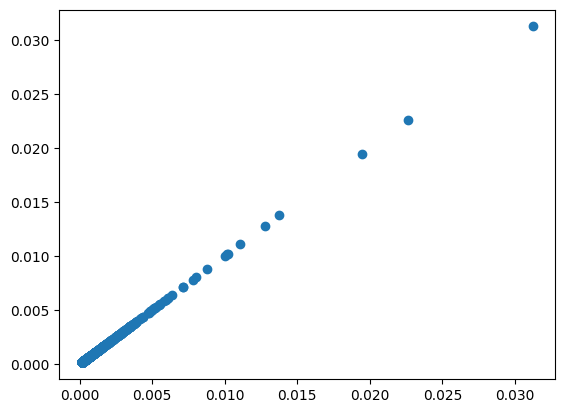

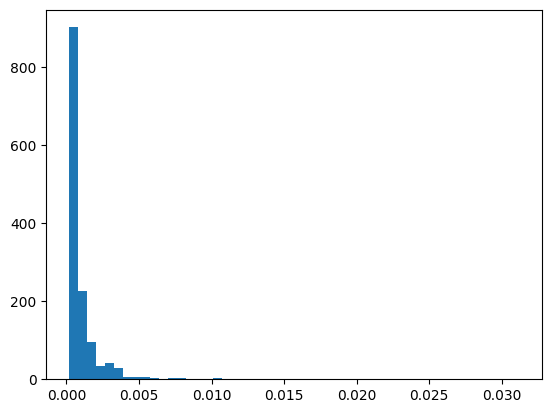

In [43]:
plot_loss_dist(zero_above)

In [44]:
test_loss_dist = make_preds(model, test_loader)
len(test_loss_dist)

351149

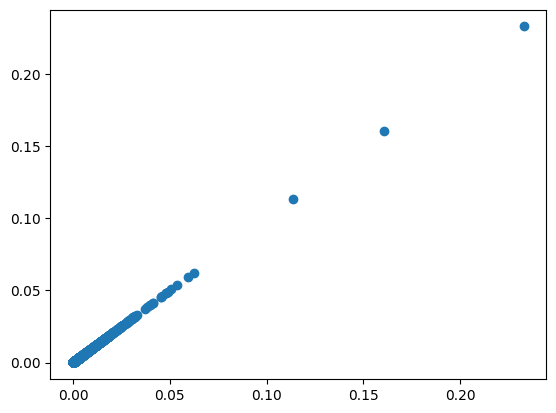

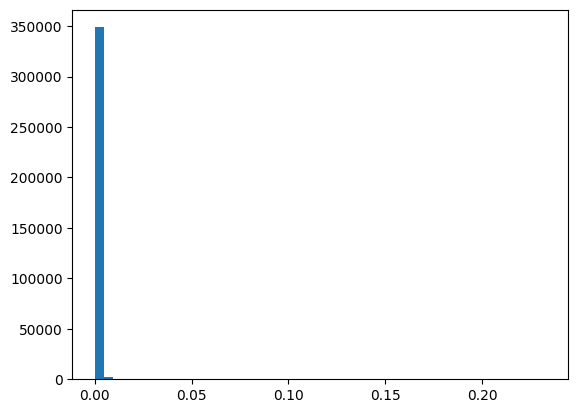

In [45]:
plot_loss_dist(test_loss_dist)

In [46]:
#total_losses = train_loss_dist[:]
#total_losses.extend(test_loss_dist)
total_losses = test_loss_dist
total_losses = np.array(total_losses)

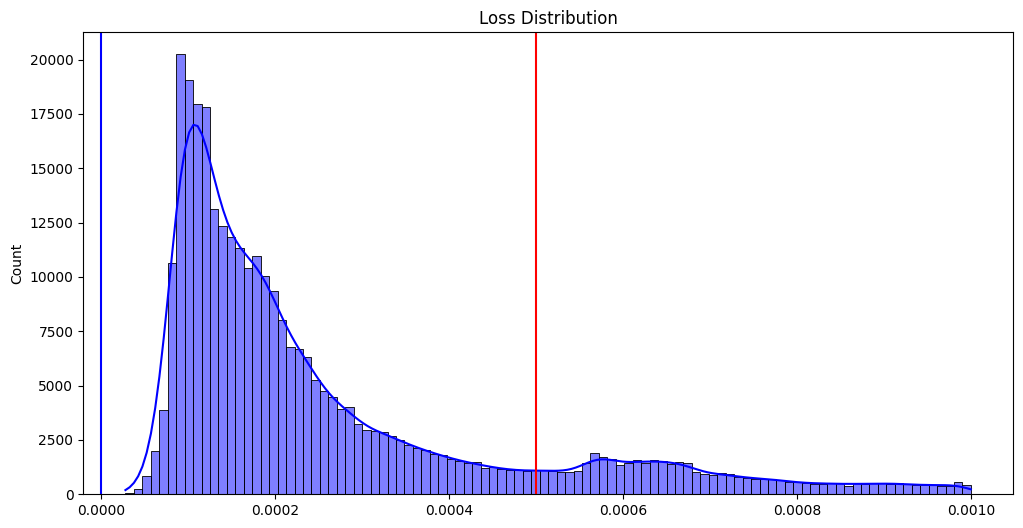

In [107]:
lower_threshold = 0.0
upper_threshold = 0.0004
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.histplot( total_losses[total_losses < 0.001],bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [105]:
def make_preds_and_classify(model, data_loader, threshold=1e-4):
    loss_dist = []
    y_true, y_pred = [], []
    y_scores = []
    model.eval()
    for x, y in data_loader:
        x = x.to(device)
        y_true.append(y)
        sample = model(x)
        loss = torch.nn.MSELoss()(x, sample)
        loss_dist.append(loss.item())
        if loss.item() < threshold:
            y_pred.append(0)
        else:
            y_pred.append(1)
        # np.exp(-losses) / np.sum(np.exp(-losses))

    losses = np.array(loss_dist)
    probs = np.exp(-losses) / np.sum(np.exp(-losses))
    
    m = np.median(losses)
    ad = np.abs(losses - m)
    mad = np.median(ad)
    probs2 =1/(1 + np.exp(-0.6745 * ad / mad))
    
    scaler = MinMaxScaler()
    scaler.fit(probs2.reshape(-1, 1))
    probs3 = scaler.transform(probs2.reshape(-1, 1))
    
    scaler = MinMaxScaler()
    scaler.fit(probs.reshape(-1, 1))
    probs4 = scaler.transform(probs2.reshape(-1, 1))
    
    probs5 = 1/(1 + np.exp(-losses))
    print(probs5.min(), probs5.max())
    
    scaler = MinMaxScaler()
    scaler.fit(probs5.reshape(-1, 1))
    probs6 = scaler.transform(probs5.reshape(-1, 1))
    
    scaler = MinMaxScaler()
    scaler.fit(losses.reshape(-1, 1))
    probs7 = scaler.transform(losses.reshape(-1,1))
    
    
    y_true = torch.cat(y_true, dim=0)
    num_ones = torch.sum(y_true == 1).item()
    print("Num ones", num_ones)
    
    acc, precision, recall, f1 = get_classification_metrics(y_true.numpy(), np.array(y_pred))
    
    print("Probs2:", get_probability_measures(y_true.numpy(), probs2))

    print("Probs2",get_lift_demotion_scores(y_true.numpy(), probs2,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    
    print("Probs3:", get_probability_measures(y_true.numpy(), probs3))

    print("Probs3",get_lift_demotion_scores(y_true.numpy(), probs3,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    print("Probs4:", get_probability_measures(y_true.numpy(), probs4))

    print("Probs4",get_lift_demotion_scores(y_true.numpy(), probs4,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    
    print("Probs5:", get_probability_measures(y_true.numpy(), probs5))

    print("Probs5",get_lift_demotion_scores(y_true.numpy(), probs5,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    
    print("Probs6:", get_probability_measures(y_true.numpy(), probs6))

    print("Probs6",get_lift_demotion_scores(y_true.numpy(), probs6,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    print("Probs7:", get_probability_measures(y_true.numpy(), probs7))

    print("Probs7",get_lift_demotion_scores(y_true.numpy(), probs7,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    
    brier, roc_auc, pr_auc = get_probability_measures(y_true.numpy(), probs)

    lift, demotion, weighted = get_lift_demotion_scores(y_true.numpy(), probs,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False)
    
    return acc, precision, recall, f1, brier, roc_auc, pr_auc, lift, demotion, weighted, losses
  

In [110]:
acc, precision, recall, f1, brier, roc_auc, pr_auc, lift, demotion, weighted, loss_dist = make_preds_and_classify(model, test_loader, 
                        threshold=0.0002)
print(f"[Test] Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}\n"
                f"\t\tBrier score loss: {brier}, ROC-AUC: {roc_auc}, PR-AUC: {pr_auc}\n"
                f"\t\tLift: {lift}, Demotion: {demotion}, Weighted Score: {weighted}\n")

KeyboardInterrupt: 

In [51]:
np.percentile(loss_dist, 45)

0.00017903795232996345

In [52]:
print(f"Test Mean: {statistics.mean(loss_dist)}, Median: {statistics.median(loss_dist)}")

Test Mean: 0.00044178546390025516, Median: 0.0001958626671694219


In [53]:
train_loss_dist = np.array(train_loss_dist)
test_zero_loss_dist = np.array(test_zero_loss_dist)

In [57]:
len(test_zero_loss_dist)

1555

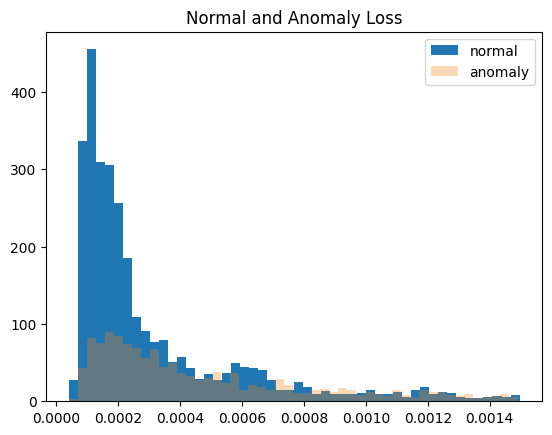

In [60]:
plt.hist(train_loss_dist[train_loss_dist < 0.0015][:3000], bins=50, label='normal', )
plt.hist(test_zero_loss_dist[test_zero_loss_dist < 0.0015], bins=50, label='anomaly', alpha=0.3)
#plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

In [61]:
tmp_train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=False
)
tmp_val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False
)

In [95]:
train_data = []

In [96]:
for x, y in tmp_train_loader:
        x = x.to(device)
        encoded = model.encode(x)
        train_data.append(encoded.cpu().numpy()[0])

In [97]:
tmp_train_np = np.vstack(train_data)

In [98]:
len(tmp_train_np)

349593

In [99]:
my_dataframe = pd.DataFrame(tmp_train_np, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4'])

In [100]:
my_dataframe['target'] = 0
my_dataframe.head()

,feature_1,feature_2,feature_3,feature_4,target
0,-0.456844,-0.416915,3.261271,-0.367754,0
1,-1.001312,0.040654,3.900383,-0.617724,0
2,-1.109361,-0.032174,3.266126,-0.907165,0
3,-1.149411,0.410407,2.562640,-0.386063,0
4,-0.309966,-0.323525,3.146597,-0.368974,0


In [101]:
my_dataframe.to_csv('train_encoded.csv', index=False)

In [81]:
val_data = []
for x, y in tmp_val_loader:
        x = x.to(device)
        encoded = model.encode(x)
        val_data.append(encoded.cpu().numpy()[0])
tmp_val_np = np.vstack(val_data)
my_dataframe = pd.DataFrame(tmp_val_np, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4'])
my_dataframe['target'] = 0
my_dataframe.head()

,feature_1,feature_2,feature_3,feature_4,target
0,-0.969221,0.007655,3.884801,-0.586203,0
1,-0.233891,-0.410067,2.915208,0.705969,0
2,-1.144147,0.057565,2.688816,-0.133561,0
3,-0.965714,0.108138,3.288925,-0.904121,0
4,-0.539195,-0.385549,3.829208,-0.188909,0


In [82]:
my_dataframe.to_csv('val_encoded.csv', index=False)

In [84]:
len(test_zero)

1555

In [85]:
test_data = []
for x, y in test_zero:
        x = x.to(device)
        encoded = model.encode(x)
        test_data.append(encoded.cpu().numpy()[0])
tmp_test_np = np.vstack(test_data)
my_dataframe = pd.DataFrame(tmp_test_np, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4'])
my_dataframe['target'] = 1
my_dataframe.head()

,feature_1,feature_2,feature_3,feature_4,target
0,-0.929174,0.187065,3.289449,-0.929838,1
1,-0.799970,-0.080788,3.207261,-0.747923,1
2,-0.344290,-0.311458,2.881476,0.583954,1
3,-0.375409,-0.681549,2.044336,-1.268746,1
4,-0.596692,0.008397,2.525027,0.385567,1


In [86]:
my_dataframe.to_csv('test_encoded.csv', index=False)

In [88]:
train_data = []
model.eval()
for x, y in tmp_train_loader:
        x = x.to(device)
        encoded = model(x)
        train_data.append(encoded.detach().cpu().numpy()[0])
tmp_train_np = np.vstack(train_data)
my_dataframe = pd.DataFrame(tmp_train_np, columns=[f'feature_{i}' for i in range(len(tmp_train_np[0]))])
my_dataframe['target'] = 0
my_dataframe.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,target
0,0.103128,0.005423,0.002111,0.002110,0.002110,0.002110,0.002106,0.088267,0.044176,0.068603,0.069070,0.332267,0.017971,0.034976,0.017672,0.003997,0.021874,0
1,0.076714,0.001503,0.000474,0.000474,0.000474,0.000474,0.000473,0.079779,0.031249,0.053530,0.051185,0.064577,0.017302,0.009798,0.011475,0.000569,0.006225,0
2,0.204514,0.004073,0.001391,0.001390,0.001391,0.001390,0.001388,0.097352,0.049365,0.066479,0.063798,0.036763,0.018251,0.031255,0.016885,0.002576,0.011495,0
3,0.216786,0.009364,0.004506,0.004503,0.004504,0.004504,0.004499,0.206662,0.080321,0.112458,0.099335,0.042568,0.230939,0.044326,0.075034,0.003154,0.019459,0
4,0.103997,0.006758,0.002714,0.002712,0.002713,0.002713,0.002707,0.137822,0.057678,0.092084,0.088449,0.366663,0.018632,0.039054,0.018028,0.002995,0.025778,0


In [89]:
my_dataframe.to_csv('train_decoded.csv', index=False)

In [90]:
val_data = []
model.eval()
for x, y in tmp_val_loader:
        x = x.to(device)
        encoded = model(x)
        val_data.append(encoded.detach().cpu().numpy()[0])
tmp_val_np = np.vstack(val_data)
my_dataframe = pd.DataFrame(tmp_val_np, columns=[f'feature_{i}' for i in range(len(tmp_val_np[0]))])
my_dataframe['target'] = 0
my_dataframe.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,target
0,0.074686,0.001564,0.000499,0.000499,0.000499,0.000499,0.000498,0.077451,0.030967,0.053118,0.051142,0.074765,0.017498,0.010171,0.011732,0.000628,0.006588,0
1,0.049733,0.008051,0.004591,0.004585,0.004587,0.004586,0.004581,0.077429,0.035363,0.064613,0.066714,0.782401,0.248486,0.032425,0.076878,0.007677,0.037671,0
2,0.165073,0.007960,0.003944,0.003939,0.003941,0.003940,0.003937,0.088419,0.048493,0.067387,0.066466,0.097605,0.245507,0.043527,0.083043,0.008064,0.020756,0
3,0.180458,0.004075,0.001388,0.001387,0.001387,0.001387,0.001384,0.152998,0.060820,0.087926,0.079889,0.040501,0.017053,0.027020,0.015049,0.001294,0.011510,0
4,0.052556,0.002098,0.000742,0.000741,0.000741,0.000741,0.000740,0.056393,0.025803,0.046473,0.047759,0.342511,0.017364,0.013114,0.012936,0.001437,0.011320,0


In [91]:
my_dataframe.to_csv('val_decoded.csv', index=False)

In [93]:
test_data = []
model.eval()
for x, y in test_zero:
        x = x.to(device)
        encoded = model(x)
        test_data.append(encoded.detach().cpu().numpy()[0])
tmp_test_np = np.vstack(test_data)
my_dataframe = pd.DataFrame(tmp_test_np, columns=[f'feature_{i}' for i in range(len(tmp_test_np[0]))])
my_dataframe['target'] = 1
my_dataframe.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,target
0,0.178235,0.004092,0.001385,0.001384,0.001385,0.001385,0.001382,0.187452,0.067588,0.099797,0.088322,0.037695,0.016581,0.025643,0.014339,0.000949,0.011309,1
1,0.160679,0.005038,0.001818,0.001817,0.001817,0.001817,0.001814,0.128890,0.057481,0.083225,0.078581,0.087946,0.017527,0.033494,0.016728,0.002277,0.015526,1
2,0.058200,0.008075,0.004516,0.004511,0.004512,0.004512,0.004506,0.086454,0.038680,0.068736,0.069744,0.685208,0.248734,0.033047,0.076935,0.006831,0.034605,1
3,0.241587,0.034055,0.016348,0.016341,0.016343,0.016343,0.016325,0.199012,0.109312,0.125691,0.114153,0.130845,0.031713,0.621140,0.040822,0.033321,0.058654,1
4,0.094145,0.011929,0.007008,0.007001,0.007003,0.007003,0.006996,0.142683,0.058822,0.095915,0.091377,0.408193,0.374567,0.048648,0.112754,0.006849,0.036418,1


In [94]:
my_dataframe.to_csv('test_decoded.csv', index=False)